In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.testing as npt
import pandas as pd
from PIL import Image
import torch
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split

In [2]:
#for nvidia 
has_gpu = torch.cuda.is_available()
#for mac
has_mps = getattr(torch,'has_mps',False)
device = "mps" if getattr(torch,'has_mps',False) \
    else "cuda" if torch.cuda.is_available() else "cpu"

print("GPU is", "available" if has_gpu else "NOT AVAILABLE")
print("MPS (Apple Metal) is", "AVAILABLE" if has_mps else "NOT AVAILABLE")
print(f"Target device is {device}")

batch_size = 64
num_classes = 8
num_epochs = 25

GPU is NOT AVAILABLE
MPS (Apple Metal) is NOT AVAILABLE
Target device is cpu


# Opening the dataset labels file
To preprocess and combine the labels of the images with their identifying attributes and training features

In [3]:
attr_df = pd.read_table("./data/efigi-1.6/docs/EFIGI_attributes.txt", sep = '\s+')
attr_df['T'].unique

<bound method Series.unique of 0        1
1        0
2       -2
3        9
4        7
        ..
4453     6
4454     4
4455     3
4456     3
4457    10
Name: T, Length: 4458, dtype: int64>

In [4]:
hyper_df  = pd.read_table("./data/efigi-1.6/docs/EFIGI_HyperLeda.txt", sep = '\s+')
hyper_df

,PGC_name,PGC_no,vrad,e_vrad,vopt,e_vopt,v,e_v,vvir,zvir,z_err,type,objname,hl_names
0,PGC0000212,212.0,11230.4,4.5,11110.0,47.0,11229.3,9.0,11287.9,0.037650,0.000030,Sab,IC5381,PGC000212
1,PGC0000218,218.0,1050.3,4.8,1027.4,25.0,1049.5,4.5,1109.0,0.003699,0.000015,Sab,NGC7814,PGC1501809
2,PGC0000243,243.0,-9999.0,-9999.0,8914.3,16.3,8914.3,16.3,8841.8,0.029490,0.000054,S0,NGC7808,6dFJ0003321-104441
3,PGC0000255,255.0,878.1,4.1,-9999.0,-9999.0,878.1,4.1,932.9,0.003112,0.000014,Sm,UGC00017,PGC000255
4,PGC0000281,281.0,-9999.0,-9999.0,11490.7,16.4,11490.7,16.4,11416.0,0.038080,0.000055,Sc,PGC000281,MCG-02-01-015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4453,PGC0072806,72810.0,-9999.0,-9999.0,18356.6,15.9,18356.6,15.9,18341.9,0.061180,0.000053,S0-a,PGC072806,HCG098D
4454,PGC0072922,72920.0,6664.7,7.3,6717.8,20.8,6670.6,12.6,6648.3,0.022180,0.000042,Sb,IC1515,PGC197276
4455,PGC0072927,72930.0,7279.8,7.7,7279.0,18.5,7279.7,5.1,7257.8,0.024210,0.000017,Sbc,IC1516,HIPASSJ2356-00
4456,PGC0072930,72930.0,6668.0,5.2,6651.8,29.1,6667.5,4.1,6652.9,0.022190,0.000014,S0-a,NGC7787,MCG+00-01-005


## Merging the two data frames with only the relevant columns

In [5]:
hyper_df = hyper_df[['PGC_name','PGC_no','type']]
attr_df = attr_df[['PGCname','T','T_inf','T_sup']]
attr_df = attr_df.rename(columns={'PGCname':'PGC_name'})
attr_df = attr_df.merge(hyper_df)
attr_df

,PGC_name,T,T_inf,T_sup,PGC_no,type
0,PGC0000212,1,0,2,212.0,Sab
1,PGC0000218,0,-1,1,218.0,Sab
2,PGC0000243,-2,-3,-2,243.0,S0
3,PGC0000255,9,9,10,255.0,Sm
4,PGC0000281,7,6,9,281.0,Sc
...,...,...,...,...,...,...
4453,PGC0072806,6,4,8,72810.0,S0-a
4454,PGC0072922,4,3,4,72920.0,Sb
4455,PGC0072927,3,2,4,72930.0,Sbc
4456,PGC0072930,3,2,4,72930.0,S0-a


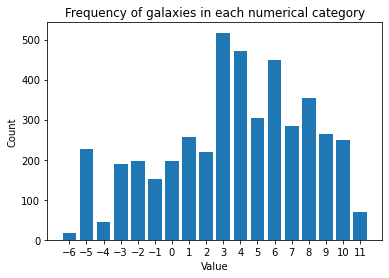

In [6]:
value_counts = attr_df['T'].value_counts()

fig, ax = plt.subplots()
ax.bar(value_counts.index, value_counts.values)
ax.set_xlabel('Value')
ax.set_ylabel('Count')
ax.set_title('Frequency of galaxies in each numerical category')
ax.set_xticks(range(-6, max(attr_df['T'])+1))
plt.show()

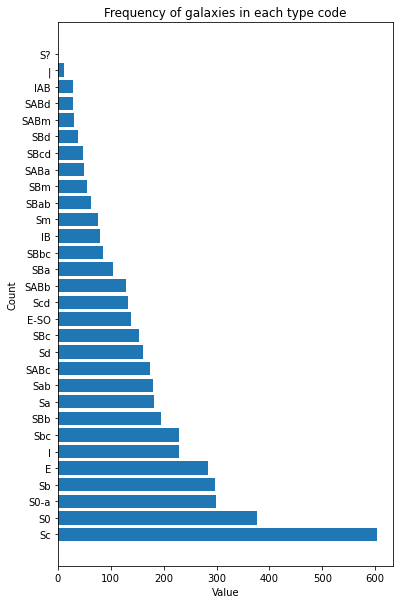

In [7]:
value_counts = attr_df['type'].value_counts()

fig, ax = plt.subplots(figsize=(6,10))
ax.barh(value_counts.index, value_counts.values)
ax.set_xlabel('Value')
ax.set_ylabel('Count')
ax.set_title('Frequency of galaxies in each type code')
plt.show()

# Encoding the numerical types to groups and naming them

This code converts type labels to a common integer, then uses the grouped labels to assign them the corresponding names of each type of galaxy

For reference, this is the overall grouping used:

k_encodings = {
    'Elliptical':(-6,-5,-4),
    'Lenticular_e':-3,
    'Lenticular_i':-2,
    'Lenticular_l':-1,
    'Irregular_m':(10,11),
    'Spiral':0,
    'Spiral_a':(1,2),
    'Spiral_b':(3,4),
    'Spiral_c':(5,6),
    'Spiral_d':(7,8),
    'Spiral_m':9
}

In [8]:
groups = {
    -6:0,
    -5:0,
    -4:0,
    -3:1,
    -2:1,
    -1:1,
    0:2,
    1:3,
    2:3,
    3:4,
    4:4,
    5:5,
    6:5,
    7:6,
    8:6,
    9:2,
    10:7,
    11:7
}

names = {
    0:'Elliptical',
    1:'Lenticular',
    2:'Spiral',
    3:'Spiral_a',
    4:'Spiral_b',
    5:'Spiral_c',
    6:'Spiral_d',
    7:'Irregular_m',
}


attr_df['groupT'] = attr_df['T'].map(groups)
attr_df['groupT'] = attr_df['groupT'].astype(int)
attr_df['labels'] = attr_df['groupT'].map(names)
attr_df[['PGC_name','T','groupT','labels']]
attr_df

,PGC_name,T,T_inf,T_sup,PGC_no,type,groupT,labels
0,PGC0000212,1,0,2,212.0,Sab,3,Spiral_a
1,PGC0000218,0,-1,1,218.0,Sab,2,Spiral
2,PGC0000243,-2,-3,-2,243.0,S0,1,Lenticular
3,PGC0000255,9,9,10,255.0,Sm,2,Spiral
4,PGC0000281,7,6,9,281.0,Sc,6,Spiral_d
...,...,...,...,...,...,...,...,...
4453,PGC0072806,6,4,8,72810.0,S0-a,5,Spiral_c
4454,PGC0072922,4,3,4,72920.0,Sb,4,Spiral_b
4455,PGC0072927,3,2,4,72930.0,Sbc,4,Spiral_b
4456,PGC0072930,3,2,4,72930.0,S0-a,4,Spiral_b


In [9]:
df2 = attr_df.groupby(['groupT'])['groupT'].count()
df2

groupT
0    289
1    537
2    459
3    476
4    989
5    751
6    640
7    317
Name: groupT, dtype: int64

# Creating Transformations
For testing and training images to normalize them

In [10]:
transform_train = transforms.Compose([
    transforms.RandomCrop(224, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Custon Dataloader for image files


In [11]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, img_list, label_list, transform=None):
        self.img_list = img_list
        self.label_list = label_list
        self.transform= transform

    def __len__(self):
        return len(self.img_list)
    
    def __getitem__(self, idx):
        img_name = self.img_list[idx]
        img = Image.open(f'./data/efigi-1.6/img_data/png/{img_name}.png').convert('RGB')
        if self.transform:
            img = self.transform(img)
        label = self.label_list[idx]
        return img, label


In [12]:
#features that lead to analysis of galaxy shape
X = attr_df['PGC_name'].to_list()

#label for galaxy 
y = attr_df['groupT'].to_list()

#creating train and test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=1)

train_dataset = CustomDataset(X_train, y_train, transform_train)
print(len(train_dataset))
test_dataset = CustomDataset(X_test, y_test, transform_test)
print(len(test_dataset))
train_dataset, valid_dataset = random_split(train_dataset, lengths=[3000, 789])
# dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0)


3789
669


In [13]:
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    drop_last=True,
    num_workers=0,
    shuffle=False
)
valid_loader = DataLoader(
    dataset=valid_dataset,
    batch_size=batch_size,
    drop_last=False,
    num_workers=0,
    shuffle=False
)
test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    drop_last=False,
    num_workers=0,
    shuffle=False
)

Mini_batch Dimensions: [B, C, H, W] = 
torch.Size([64, 3, 224, 224])


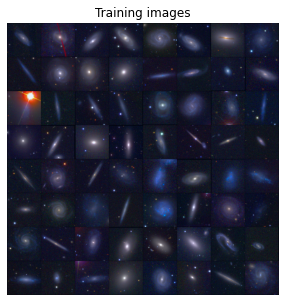

Labels = 
[[5 3 2 3 4 4 1 6]
 [6 3 2 0 6 4 4 4]
 [7 6 6 6 3 6 5 6]
 [1 3 0 1 5 4 3 4]
 [4 4 4 6 7 3 7 7]
 [4 4 7 6 2 1 4 7]
 [4 4 3 1 1 7 4 4]
 [2 5 6 0 3 1 5 6]]


In [14]:
import torchvision.utils as vutils

%matplotlib inline
import matplotlib.pyplot as plt

im_batch = next(iter(train_loader))
print('Mini_batch Dimensions: [B, C, H, W] = ')
print(im_batch[0].shape)
plt.figure(figsize=(5, 5))
plt.title("Training images")
plt.axis("off")
plt.imshow(
    np.transpose(
        vutils.make_grid(im_batch[0][:64], nrow=8, padding=1, normalize=True), (1, 2, 0)
    )
)
plt.show()
print("Labels = " )
print(im_batch[1][:64].data.numpy().reshape(8,-1))

In [15]:
from torchvision.models import wide_resnet50_2, Wide_ResNet50_2_Weights, resnext50_32x4d, ResNeXt50_32X4D_Weights, resnext101_32x8d, ResNeXt101_32X8D_Weights
# The model
# model = wide_resnet50_2(weights=Wide_ResNet50_2_Weights)
model = resnext50_32x4d(weights=ResNeXt50_32X4D_Weights)
model

c:\Users\Sai\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

In [16]:
# from torchinfo import summary

# Freeze the layers you do not want to update
# for param in model.parameters():
#    param.requires_grad = False

# # Unfreeze layers you want to update
# model.fc.requires_grad = True

# Add new layers
model.fc = torch.nn.Sequential(
    torch.nn.Linear(2048, 128),
    torch.nn.ReLU(inplace=True),
    torch.nn.Linear(128, num_classes),
)

# summary(model, input_size=(batch_size, 3, 128, 128))

In [17]:
model = model.to(device)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

In [18]:
from sklearn import metrics

def accuracy(model, data_loader, device):
    with torch.no_grad():
        true_pred = 0
        tot_samples = 0
        for imgs, labels in data_loader:
            imgs = imgs.to(device)
            labels = labels.to(device)
            logits = model(imgs)
            _, label_pred = torch.max(logits, axis=1)
            true_pred += (label_pred==labels).sum()
            tot_samples += labels.shape[0]
        acc = (true_pred/float(tot_samples))*100
        confusion_matrix = metrics.confusion_matrix(labels, label_pred) 
        cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, False]) 
    return acc, cm_display

In [19]:
torch.manual_seed(1)
base_learning_rate = 1e-5 # for fine-tuning - low learning rates
fc_learning_rate = 1e-2

# Set different learning rates for different param_groups
optimizer = torch.optim.Adam([
    {'params': [param for name, param in model.named_parameters() if 'fc' not in name]}, 
    {'params': model.fc.parameters(), 'lr': fc_learning_rate, 'weight_decay':0.5}
    ], lr=base_learning_rate)
# Set up a Learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=int((num_epochs/20)+1), gamma=0.5)

In [20]:
# # img_list = attr_df['PGC_name'].to_list()[:200]
# # label_list = attr_df['groupT'].to_list()[:200]

# # Define loss functiion
# criterion = torch.nn.CrossEntropyLoss()

# # Define optimizer
# optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# # Stop pre-trained layers from being changed
# for param in model.parameters():
#     param.requires_grad=False

# target_categories = ['Spiral_a', 'Spiral', 'Lenticular_i', 'Spiral_m', 'Spiral_d',
#        'Spiral_c', 'Spiral_b', 'Elliptical', 'Irregular_m',
#        'Lenticular_e', 'Lenticular_l']

# model.fc = torch.nn.Linear(
#     torch.nn.Linear(2048, 128),
#     torch.nn.ReLU(inplace=True),
#     torch.nn.Linear(128, num_classes),)

# for epoch in range(200):
#     running_loss = 0.0
#     train_loss = 0.0
#     for i, data in enumerate(train_loader, 0):
#         inputs, labels = data
#         optimizer.zero_grad()
#         outputs = model(inputs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()
#         running_loss += loss.item()
#         train_loss = loss.item()*inputs.size(0)
#     print('[epoch: %d, batch: %5d] loss :%3f, percent loss: %3f, train_loss: %3f'%(epoch+1, i+1, running_loss, running_loss/len(train_loader),train_loss))
# print('done trainin')


Epoch: 001 Base Learning Rate 0.00010000 -> 0.00010000
Epoch: 001 FC Learning Rate 0.01000000 -> 0.01000000
Train Accuracy: 51.155
Validation Accuracy: 47.402
Time elapsed so far: 21.74 min
Epoch: 002 Base Learning Rate 0.00010000 -> 0.00010000
Epoch: 002 FC Learning Rate 0.01000000 -> 0.01000000
Train Accuracy: 62.874
Validation Accuracy: 57.034
Time elapsed so far: 42.22 min
Epoch: 003 Base Learning Rate 0.00010000 -> 0.00005000
Epoch: 003 FC Learning Rate 0.01000000 -> 0.00500000
Train Accuracy: 69.395
Validation Accuracy: 59.189
Time elapsed so far: 63.04 min
Epoch: 004 Base Learning Rate 0.00005000 -> 0.00005000
Epoch: 004 FC Learning Rate 0.00500000 -> 0.00500000
Train Accuracy: 72.554
Validation Accuracy: 61.090
Time elapsed so far: 83.40 min
Epoch: 005 Base Learning Rate 0.00005000 -> 0.00005000
Epoch: 005 FC Learning Rate 0.00500000 -> 0.00500000
Train Accuracy: 73.981
Validation Accuracy: 60.076
Time elapsed so far: 104.53 min
Epoch: 006 Base Learning Rate 0.00005000 -> 0.000

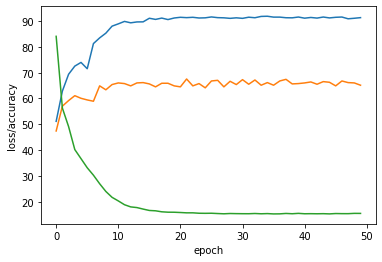

Total Train Time: 999.68 min


In [21]:
import time

track_loss = []
tr_acc_ls = []
vl_acc = []
start_time = time.time()
for epoch in range(num_epochs):
    model = model.train()
    total_loss = 0
    for batch_idx, (imgs, labels) in enumerate(train_loader):
        imgs = imgs.to(device)
        labels = labels.to(device)

        logits = model(imgs)
        loss = torch.nn.functional.cross_entropy(logits, labels)

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        if batch_idx == 63:
            print(f"Epoch: {epoch + 1:02d}/{num_epochs:02d} | Batch: {batch_idx + 1:03d}/{len(train_loader):03d} | Loss: {loss:.5f}")
        total_loss += loss.item()

            
    track_loss.append(total_loss)
    # Tracking the Learning Rate Scheduler
    prev_lr_base = optimizer.param_groups[0]["lr"]
    prev_lr_fc = optimizer.param_groups[1]["lr"]
    scheduler.step()
    current_lr_base = optimizer.param_groups[0]["lr"]
    current_lr_fc = optimizer.param_groups[1]["lr"]
    print(f"Epoch: {epoch+1:03d} Base Learning Rate {prev_lr_base:.8f} -> {current_lr_base:.8f}")
    print(f"Epoch: {epoch+1:03d} FC Learning Rate {prev_lr_fc:.8f} -> {current_lr_fc:.8f}")

    # Evaluate Performance after each epoch
    model = model.eval()
    tr_acc, cm = accuracy(model, train_loader, device)
    tr_acc_ls.append(tr_acc)
    valid_acc, cm = accuracy(model, valid_loader, device)
    vl_acc.append(valid_acc)
    print(f"Train Accuracy: {tr_acc:0.3f}")
    print(f"Validation Accuracy: {valid_acc:0.3f}")
    print(f"Time elapsed so far: {(time.time() - start_time) / 60:.2f} min")

plt.plot(tr_acc_ls, label='train')
plt.plot(vl_acc, label='validation')
plt.plot(track_loss, label = 'loss')
plt.xlabel("epoch")
plt.ylabel("loss/accuracy")
plt.show()

print(f"Total Train Time: {(time.time() - start_time) / 60:.2f} min")

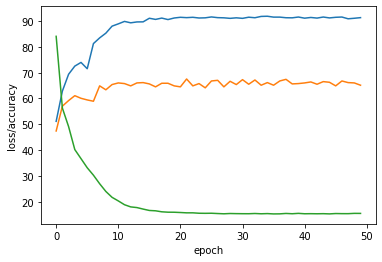

In [22]:
import math

plt.plot(tr_acc_ls, label='train')
plt.plot(vl_acc, label='validation')
plt.plot(track_loss, label = 'loss')
plt.xlabel("epoch")
plt.ylabel("loss/accuracy")
plt.show()

Test Accuracy: 65.471


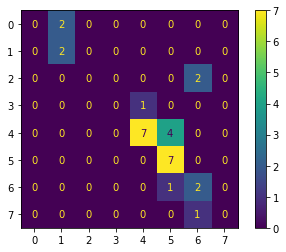

In [23]:
model = model.eval()
ts_acc, cm = accuracy(model, test_loader, device)
print(f"Test Accuracy: {ts_acc:0.3f}")
try:
    cm.plot()
except Exception:
    pass